# Analyse_MHWDrivers_tiles_v1.py
The heat budget is calculated for each tile of the Arctic NAPA domain. Each of the 160 tiles is composed of 20x20 grid cells covering the NAPA domain where sea ice is above 15% in March.
This script determines the dominating drivers of each marine heatwave:
* I. MHWs are first detected for each tile, then the heat budget terms and anomalies are integrated over onset and decay. 
* II. A few specific events are investigated to make sure everything is fine. 
* III. Some statistical analysis can be implemented, looking at all MHWs together.

This script also uses the residuals to calculate some uncertainty bounds.

BR, 17/01/2023

v1: publishable version revamped on 29/07/2023

In [1]:
import xarray as xr
import proplot as pplt
import numpy as np
import pandas as pd
import xesmf as xe
import marineHeatWaves as mhw # from https://github.com/ecjoliver/marineHeatWaves
from pathlib import Path
import dask
pplt.rc['figure.facecolor'] = 'white'

In [2]:
from dask_jobqueue import SGECluster
from dask.distributed import Client

cluster = SGECluster(
    queue="compute",
    cores=30,          # Total number of cores per job
    processes=5,        # Cores/processes = threads/worker
    walltime="12:00:00",
    memory="250GB",    # Total amount of memory per job
    local_directory="~/Projects/SiberianHW/src/dask-worker-space/",
    scheduler_options={
        "dashboard_address": ":7880",
    },
)

cluster.scale(jobs=5)          # Number of workers
client = Client(cluster)    # Connect to that cluster
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SGECluster
Dashboard: /proxy/7880/status,
Dashboard: /proxy/7880/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://129.173.118.14:43671,Workers: 0
Dashboard: /proxy/7880/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Preprocessing
Define paths and load the tiled heat budgets and MLT.

In [3]:
# Path to data and figures
Path2proc = Path(str(Path.home())+"/Projects/SiberianHW/data/processed/")
Path2tiles = Path2proc.joinpath("tiles/")
Path2figs = Path(str(Path.home())+"/Projects/SiberianHW/figures/")
# Load MLT for tiles
ds_MLT = xr.open_dataset(Path2proc.joinpath('MLT_tiles_3Oceans.nc'))
# Load Ice Properties for tiles
ds_Ice = xr.open_dataset(Path2proc.joinpath('IceProp_tiles_3Oceans.nc')).drop('month')
# Load the tiles grid
ds_tiles_grid = xr.open_dataset(Path2proc.joinpath('TilesMHWAnalysis_3Oceans_over300.nc'))
# Load Heat Budgets for tiles
ds_HB_top = xr.open_dataset(Path2proc.joinpath("HeatBudgetMixLayer_Tiles_20142021_JGRo.nc"))

#### HB Climatology and Anomalies
The focus is on anomalies of the Heat Budget terms, not the raw terms. So we first need to calculate them:
 - First calculate climatology, using same method as the mhw algorith
 - Then calculate anomalies by removing climatology.

In [4]:
def smoothedClima_mhw(ds):
    """Replicate the climatology calculation used in the marineHeatWave.py algorithm."""
    if ~np.isin("time",ds.dims):
        print("No 'time' dimensions in the dataset")
        return
    # Calculate a rolling mean first, with a 11 days window. 
    ds_rolled = ds.rolling(time=11, min_periods=1, center=True).mean()
    # Calculate the mean over dayofyear
    ds_clim_doy = ds_rolled.groupby("time.dayofyear").mean()
    # If I just smooth over that, my beginning and end will be weird.
    # A solution is to replicate 3 times, do the running average, and get the middle year.
    stackedClim = xr.concat([ds_clim_doy,ds_clim_doy,ds_clim_doy],dim='year').stack(time={'year','dayofyear'})
    # Smooth the time series
    smoothedClim = stackedClim.rolling(time=31, 
                                       min_periods=1,
                                       center=True).mean()
    # Extract the middle year and rearrange the dimensions to only keep "dayofyear"
    tmpSmooClim = smoothedClim.where(smoothedClim.year==1,drop=True).drop('year')
    ds_smoothedClim = tmpSmooClim.rename({'time':'dayofyear'}).assign_coords(dayofyear=ds_clim_doy.dayofyear.data)
    return ds_smoothedClim

In [5]:
# ds_HB_top = ds_HB[['Tendency_top','TotAdv_top','Qsr_net_top','Vert_Flux','Resi_top']].compute()
# Climatology
Climato_HB = smoothedClima_mhw(ds_HB_top)
# Remove climatology to get Anomalies
ds_HBAnom = ds_HB_top.groupby("time.dayofyear") - Climato_HB
ds_HBAnom.attrs['units'] = '°C.d$^{-1}$'

## I. Calculate Marine Heatwaves drivers

### 1. Detect Marine Heatwaves
Loop over the tiles and uses the MHW algorithm to detect marine heatwaves. The `xmhw` doesn't work properly yet, so rather use the numpy-based algorithm.
Then concat all the results and add a couple of post-processing steps, such as renaming the categories to numbers or filter low-intensity mhws out.

In [6]:
# Extract the time
timeOrd=np.array([pd.to_datetime(x).toordinal() for x in ds_MLT.time.values])
# Initialize a dictionary
df_mhws,df_clims = {},{}
# Loop over all tiles
for ind,tile in enumerate(ds_MLT.tiles):
    # Run algorithm to detect MHW
    outmhw, clims = mhw.detect(timeOrd,ds_MLT.toce.sel(tiles=tile).values)
    # Add the results to the dictionary of pd.dataframes
    df_mhws[ind] = pd.DataFrame(outmhw).to_xarray().rename({'index':'mhw'})
    df_clims[ind] = pd.DataFrame(clims).to_xarray()
# Then convert this dictionary into a dataset
ds_mhws = xr.concat(list(df_mhws.values()),pd.Index(ds_MLT.tiles, name="tiles"))
ds_clims = xr.concat(list(df_clims.values()),pd.Index(ds_MLT.tiles, name="tiles"))
# Add some coordinates
ds_mhws = ds_mhws.assign_coords({'latitude':('tiles',ds_MLT.latitude.values),
                                   'longitude':('tiles',ds_MLT.longitude.values)})
ds_clims = ds_clims.assign_coords({'latitude':('tiles',ds_MLT.latitude.values),
                                   'longitude':('tiles',ds_MLT.longitude.values)})

ds_clims.attrs['units'] = "°C"
ds_clims.attrs['Description'] = "Smoothed Climatology and Threshold for tiled Mixed-Layer Temperature. "\
        +"Calculated usingMLT from 3Oceans model, over tiled Arctic domain (ice criteria), "\
        +"with reprocessed Mixed-Layer. Eric Oliver's MarineHeatwave algorithm."
ds_clims.attrs['Source'] = "Made with DriversMHWs_Tiles3Oceans.py script, by BR, 30/01/2023"
# ds_clims.to_netcdf(Path2proc.joinpath("ClimThreshSmooth_MLT_Tiled3O.nc"))

/data/home/brichaud/Projects/SiberianHW/src/marineHeatWaves.py:411: RuntimeWarning: invalid value encountered in double_scalars
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) / (tt_end-tt_start-tt_peak))
/data/home/brichaud/Projects/SiberianHW/src/marineHeatWaves.py:411: RuntimeWarning: invalid value encountered in double_scalars
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) / (tt_end-tt_start-tt_peak))
/data/home/brichaud/Projects/SiberianHW/src/marineHeatWaves.py:411: RuntimeWarning: invalid value encountered in double_scalars
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) / (tt_end-tt_start-tt_peak))
/data/home/brichaud/Projects/SiberianHW/src/marineHeatWaves.py:411: RuntimeWarning: invalid value encountered in double_scalars
  mhw['rate_decline'].append((mhw_relSeas[tt_peak] - mhw_relSeas[-1]) / (tt_end-tt_start-tt_peak))
/data/home/brichaud/Projects/SiberianHW/src/marineHeatWaves.py:411: RuntimeWarning: invalid 

In [7]:
# Convert categories from string to number
cat = ds_mhws.category
cat_num1=xr.where(cat=='Moderate',1,cat)
cat_num2=xr.where(cat_num1=='Strong',2,cat_num1)
cat_num3=xr.where(cat_num2=='Severe',3,cat_num2)
cat_num4=xr.where(cat_num3=='Extreme',4,cat_num3).astype('f')
ds_mhws['category'] = cat_num4

In [8]:
# Remove MHWs with mean intensity less than 0.1, to filter out some of the winter MHWs
cond = (ds_mhws.intensity_mean>0.1)
ds_mhws_filter = ds_mhws.where(cond)
ds_mhws_filter['n_events'] = ds_mhws_filter.time_start.count(dim='mhw')
# Need to convert the dates from datetime to np.datetime64, to save to netcdf
ds_mhws_filter['date_start']=xr.DataArray(ds_mhws_filter.date_start.to_pandas().astype('datetime64'))
ds_mhws_filter['date_peak']=xr.DataArray(ds_mhws_filter.date_peak.to_pandas().astype('datetime64'))
ds_mhws_filter['date_end']=xr.DataArray(ds_mhws_filter.date_end.to_pandas().astype('datetime64'))
# Some description
ds_mhws_filter.attrs['Description'] = "Detection and properties of Marine Heatwaves. "\
        +"Detected using Mixed-Layer Temperature from 3Oceans model, over tiled Arctic domain (ice criteria), "\
        +"with reprocessed Mixed-Layer. Eric Oliver's MarineHeatwave algorithm. "\
        +"All MHW with intensity_mean < 0.1°C are filtered out; categories are numbered."
ds_mhws_filter.attrs['Source'] = "Made with DriversMHWs_Tiles3Oceans.py script, by BR, 13/04/2023"
# ds_mhws_filter.to_netcdf(Path2proc.joinpath("MHWfiltMean0.1_DetectionProperties_TiledMLT.nc"))

### 2. Integrate HB terms over onset and decline
The integratation requires a loop of loops, and is farily slow to process. Once executed once, the first cell can be commented out and the dataset can be loaded.

In [9]:
# tempdict1 = {}
# tempdict2 = {}#xr.Dataset(coords={'Box':BoxNames})
# for ind,tile in enumerate(ds_mhws_filter.tiles):
#     # print(ind)
#     df_mhw_attr_onset = pd.DataFrame()
#     df_mhw_attr_decay = pd.DataFrame()
#     ds_HBAnom_tile = ds_HBAnom.isel(tiles=ind)

#     for ind2, nmhw in enumerate(ds_mhws_filter.mhw):
#         StartHW = ds_mhws_filter.index_start.sel(tiles=tile,mhw=nmhw).astype('int')
#         PeakHW = ds_mhws_filter.index_peak.sel(tiles=tile,mhw=nmhw).astype('int')
#         EndHW = ds_mhws_filter.index_end.sel(tiles=tile,mhw=nmhw).astype('int')
#         # DatePeak = ds_mhws_filter.date_peak.sel(tiles=tile,mhw=nmhw)
#         # MHWonset_HBanoms = ds_HBAnom.sel(tiles=tile).isel(time=slice(StartHW.values,PeakHW.values+1))
#         MHWonset_HBanoms = ds_HBAnom_tile.isel(time=slice(StartHW.values,PeakHW.values+1))
#         MHWonset_HBanoms_sum = MHWonset_HBanoms.sum(dim='time',min_count=1).to_array().rename({'variable':'HBTerms'})
#         df_mhw_attr_onset[ind2] = MHWonset_HBanoms_sum.to_dataframe(name='mhw').mhw
#         MHWdecay_HBanoms = ds_HBAnom_tile.isel(time=slice(PeakHW.values,EndHW.values+1))
#         MHWdecay_HBanoms_sum = MHWdecay_HBanoms.sum(dim='time',min_count=1).to_array().rename({'variable':'HBTerms'})
#         df_mhw_attr_decay[ind2] = MHWdecay_HBanoms_sum.to_dataframe(name='mhw').mhw

#     tempdict1[ind] = xr.DataArray(df_mhw_attr_onset.transpose()).rename({'dim_0':'mhw'})
#     tempdict2[ind] = xr.DataArray(df_mhw_attr_decay.transpose()).rename({'dim_0':'mhw'})
    
# ds_mhw_attr_onset = xr.concat(list(tempdict1.values()),pd.Index(ds_HBAnom.tiles, name="tiles")).to_dataset(dim="HBTerms")
# ds_mhw_attr_decay = xr.concat(list(tempdict2.values()),pd.Index(ds_HBAnom.tiles, name="tiles")).to_dataset(dim="HBTerms")
# ds_mhw_attr = xr.concat([ds_mhw_attr_onset,ds_mhw_attr_decay],pd.Index(['Onset','Decay'], name="trend"))
# print('Done')
# # Some descriptions before saving 
# ds_mhw_attr.attrs['Description'] = "Integration of Heat Budget Anomalies over Marine Heatwaves onset and decay. "\
#     +"MHW are detected with Marine Heatwaves Algorithm and filtered for intensity_mean > 0.1°C"\
#     +"(MHWfiltMean0.1_DetectionProperties_TiledMLT.nc). "\
#     +"HBAnoms are calculated by removing smoothed climatology calculated following method from MHW algorithm. "\
#     +"Integration of peak value is both in onset and decay."
# ds_mhw_attr.attrs['Units'] = "°C"
# ds_mhw_attr.attrs['Source'] = "Made with DriversMHWs_Tiles3Oceans.py script, by BR, 13/04/2023"
# # ds_mhw_attr.to_netcdf(Path2proc.joinpath("IntegratedHBTerms_forMHWAttribution.nc"))

In [10]:
ds_mhw_attr = xr.open_dataset(Path2proc.joinpath("IntegratedHBTerms_forMHWAttribution.nc"))

## II. Specific events
Investigate the Summer 2020 Siberian heatwave event. This allows to validate the methodology and to better understand how a specific event can evolve. 
Other events can easily be analysed by changing the tile number and the time range.

In [1]:
# A few plotting specifications. This is very ugly... But it works...
cycleCol = pplt.get_colors(pplt.Cycle('default',5))
CycleHB = cycleCol
CycleHB[0],CycleHB[4]='k','grey6'
CycleHB[1:4]=['cobalt','ocher','wine red']
HBlabel2plot = ['Tendency','Lateral\nHeat Flux','Surface\nHeat Flux','Bottom\nHeat Flux','Residual']

NameError: name 'pplt' is not defined

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/proplot/axes/cartesian.py:646: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_major_formatter(formatter)
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


Text(0.5, 0.98, 'Siberian Marine Heatwave, Summer 2020 (74.0°N, 70.6°E)')

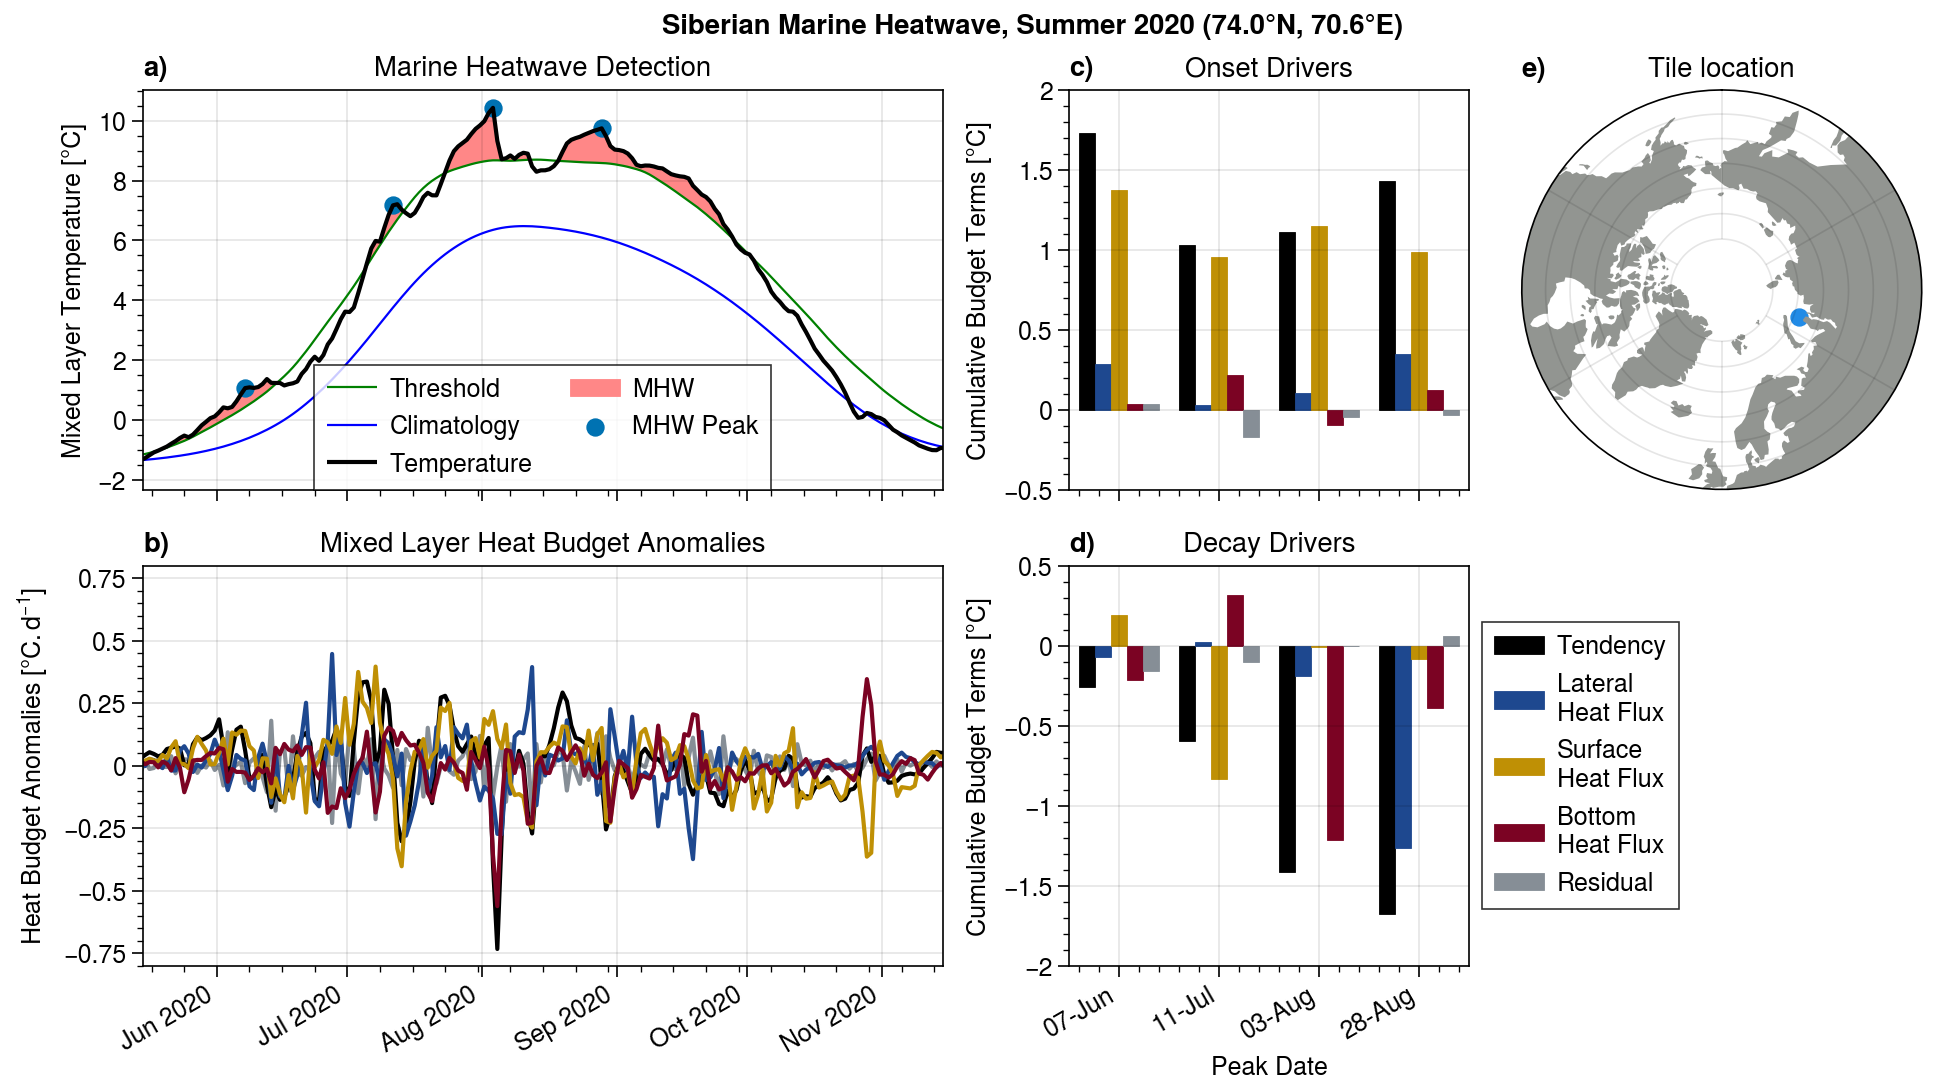

In [12]:
tile=67 # On the Siberian Shelf.
HBterms2plot = ['Tendency_top','TotAdv_top','Qsr_net_top','Vert_Flux','Resi_top']
Drivers2plot = ds_mhw_attr[HBterms2plot].isel(tiles=tile).to_array()
Drivers2plot = Drivers2plot.dropna(dim='mhw')
MHW2plot = ds_mhws_filter.isel(tiles=tile).dropna(dim='mhw')
DatesMHW = MHW2plot.date_peak.dt.strftime('%d-%b').data
# Create a plot
array=[[1,1,3,0],[1,1,3,0],[2,2,4,0],[2,2,4,0]]
fig = pplt.figure(refaspect=2,sharey=0, sharex=3, spanx=False, refwidth=4)
axs = fig.subplots(array,)
# Plot SST, seasonal cycle, and threshold
h0 = axs[0].plot(ds_MLT.time, ds_clims.thresh.isel(tiles=tile), c='g', lw=0.8, label='Threshold')
h1 = axs[0].plot(ds_MLT.time, ds_clims.seas.isel(tiles=tile), c='b', lw=0.8, label='Climatology')
h2 = axs[0].plot(ds_MLT.time, ds_MLT.isel(tiles=tile).toce, c='k', label='Temperature')
[h3,h4] = axs[0].area(ds_MLT.time, ds_clims.thresh.isel(tiles=tile), ds_MLT.isel(tiles=tile).toce, 
            negpos=True, negcolor='None', poscolor='red4', label='MHW')
h5 = axs[0].scatter(ds_MLT.time.isel(time=MHW2plot.index_peak.astype('int')),
               MHW2plot.intensity_max_abs, label='MHW Peak')
axs[0].format(ylabel='Mixed Layer Temperature [°C]',title="Marine Heatwave Detection",xlabel='')
axs[0].legend([h0,h4,h1,h5,h2],ncol=2)
# Plot Heat Budget terms for mixed layer
axs[1].plot(ds_HBAnom.isel(tiles=tile).to_array().transpose()[:,:-1], cycle=CycleHB[:-1])
axs[1].plot(ds_HBAnom.isel(tiles=tile).to_array().transpose()[:,4], color='grey6',zorder=0)
axs[1].format(xrotation=30, ylabel='Heat Budget Anomalies [$°C.d^{-1}$]',xlabel='', 
              title="Mixed Layer Heat Budget Anomalies",
              ylim=[-0.8,0.8]
             )
axs[0:1].format(xlim= [np.datetime64('2020-05-15'),np.datetime64('2020-11-15')],
               xformatter='%b %Y')
# Bar charts for cumulative heat budget terms
# Onset
hb=axs[2].bar(range(len(Drivers2plot.mhw)),
              Drivers2plot.sel(trend='Onset').transpose(), 
              cycle=CycleHB,
              labels=HBlabel2plot)
axs[2].format(title='Onset Drivers', ylim=[-0.5,2], ylabel="Cumulative Budget Terms [°C]")
# Decay
axs[3].bar(range(len(Drivers2plot.mhw)),
           Drivers2plot.sel(trend='Decay').transpose(), 
           cycle=CycleHB,
           labels=HBlabel2plot)
axs[3].format(xrotation=30, title='Decay Drivers', xlabel='Peak Date',
              ylim=[-2,0.5], ylabel="Cumulative Budget Terms [°C]")
axs[3].legend(ncol=1,loc='r')
axs[2:3].format(xlim=[8.5,12.5], xticklabels=list(DatesMHW[8:13]),)
axs.format(abc='a)',)
# Map of location of tile
proj=pplt.Proj('nplaea')
ax_end = fig.subplot(2,4,(4), projection=proj,abc='a)',number=5)
ax_end.scatter(ds_HBAnom.isel(tiles=tile).longitude.values, 
               ds_HBAnom.isel(tiles=tile).latitude.values, 
               color='blue6')
ax_end.format(boundinglat=50, land=True, landcolor='grey', title=r'Tile location')
fig.suptitle("Siberian Marine Heatwave, Summer 2020 ({0:.1f}°N, {1:.1f}°E)".format(MHW2plot.latitude.data,
                                                                                   MHW2plot.longitude.data))
# fig.save(Path2figs.joinpath("Fig2_SibHW2020_HeatBudget.png"),dpi=600)
# fig.save(Path2figs.joinpath("Fig2_SibHW2020_HeatBudget.svg"))

## III. Statistics of MHW drivers
Now, a statistical approach can provide a broader overview of the behaviour of MHWs in the Arctic Ocean.

### III. 0) Berserk 

First, average everything. Won't give any interesting information, but has to be done!

Text(0.5, 0.98, 'Integrated Drivers of all Arctic MHWs')

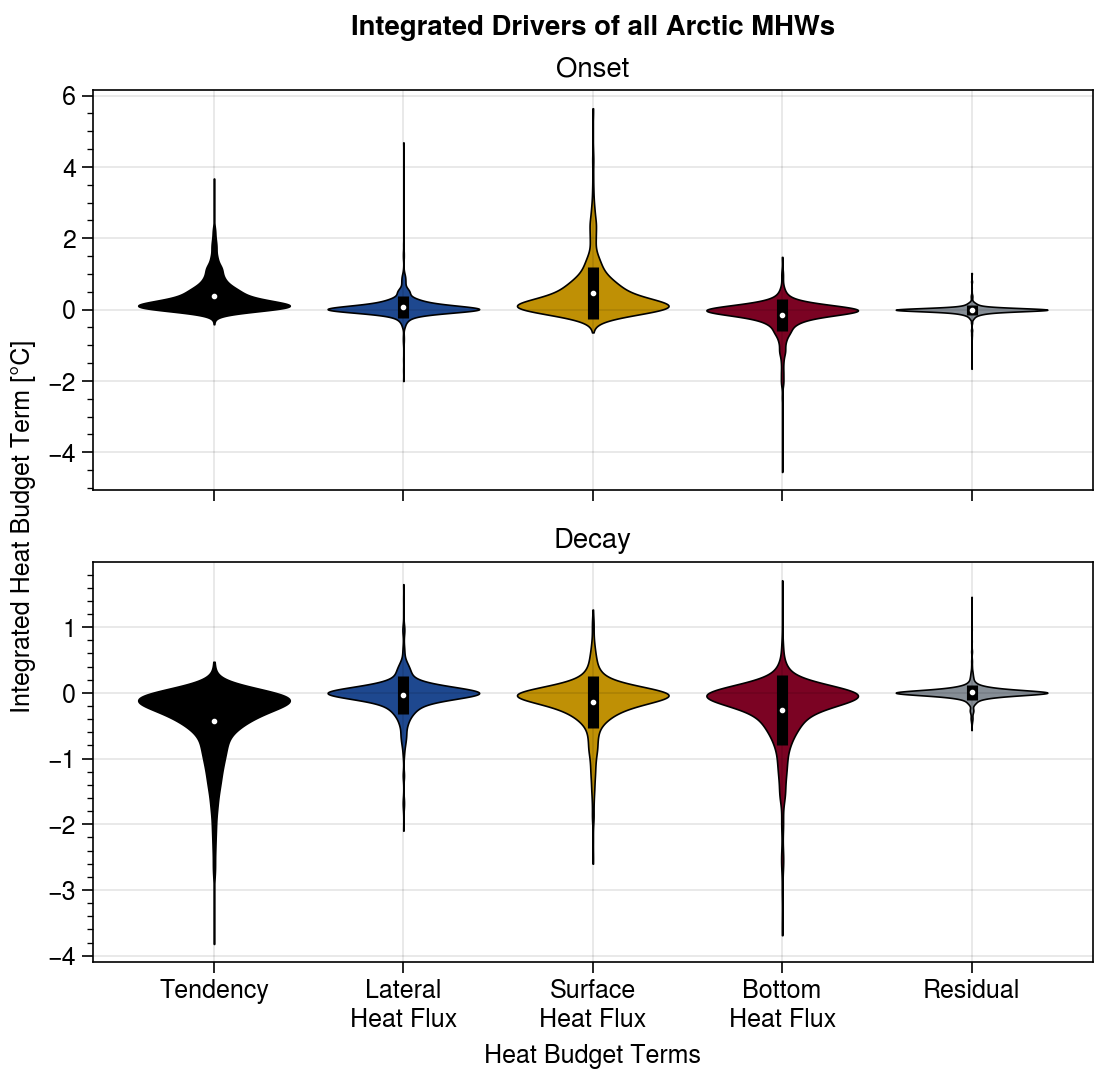

In [13]:
AvgOnset_terms=ds_mhw_attr.sel(trend='Onset').stack(Allmhw=('mhw','tiles')).dropna(dim='Allmhw').to_array()
AvgDecay_terms=ds_mhw_attr.sel(trend='Decay').stack(Allmhw=('mhw','tiles')).dropna(dim='Allmhw').to_array()
fig, ax = pplt.subplots(nrows=2,axwidth=5,axheight=2)
ax[0].violin(AvgOnset_terms.transpose(),mean=True,cycle=CycleHB,widths=0.8,points=1000)
ax[0].format(title='Onset',)
ax[1].violin(AvgDecay_terms.transpose(),mean=True,cycle=CycleHB,widths=0.8,points=1000)
ax[1].format(title='Decay',
             xticklabels=HBlabel2plot,)
ax.format(ylabel='Integrated Heat Budget Term [°C]',xlabel='Heat Budget Terms')
fig.suptitle('Integrated Drivers of all Arctic MHWs')
# fig.save(Path2figs.joinpath("ViolinPlot_allMHWDrivers.png"),dpi=400)

### III. 1) Rank the drivers
For each MHW, divide each term by the `Tendency_top` to rank the drivers. 

We use this step to calculate uncertainties on the ranking, buy using the residuals. The heat budget is $Tendency = Lateral+Bottom+Surface+Residual$.
So the residual can be added to each of those terms, and for any of the four resulting situations, the ranking can be calculated.
Then account for the dominating driver over all MHWs.

In [14]:
# Start by creating a ds with residual added to each of the 4 interesting terms
ds_mhw_attr_wres = ds_mhw_attr.copy() # Copy initial ds
# Loop over variables
for var in ['Tendency_top','TotAdv_top','Qsr_net_top','Vert_Flux']:
    # Add residual to each term. Need to account for the fact that residual should be substracted from Tendency
    if var=='Tendency_top':
        ds_mhw_attr_wres[var+'_wres'] = ds_mhw_attr_wres[var]-ds_mhw_attr_wres['Resi_top']
    else:
        ds_mhw_attr_wres[var+'_wres'] = ds_mhw_attr_wres[var]+ds_mhw_attr_wres['Resi_top']

# Create specific dataframe containing one term with residual and the 3 others without, divide by Tendency.
# Then split into onset and decay, and rank for each phase.
# Tendency with Residual
ds_dTdtWRes = ds_mhw_attr_wres[['TotAdv_top','Qsr_net_top','Vert_Flux']]/ds_mhw_attr_wres['Tendency_top_wres']
df_dTdtWRes_Onset = ds_dTdtWRes.sel(trend='Onset').drop_vars(['trend']).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_dTdtWRes_Onset_ranks = df_dTdtWRes_Onset.rank(axis=1,ascending=False)
df_dTdtWRes_Decay = ds_dTdtWRes.sel(trend='Decay').drop_vars(['trend']).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_dTdtWRes_Decay_ranks = df_dTdtWRes_Decay.rank(axis=1,ascending=False)
# Advection with Residual
ds_AdvWRes = ds_mhw_attr_wres[['TotAdv_top_wres','Qsr_net_top','Vert_Flux']]/ds_mhw_attr_wres['Tendency_top']
df_AdvWRes_Onset = ds_AdvWRes.sel(trend='Onset').drop_vars(['trend']).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_AdvWRes_Onset_ranks = df_AdvWRes_Onset.rank(axis=1,ascending=False)
df_AdvWRes_Decay = ds_AdvWRes.sel(trend='Decay').drop_vars(['trend']).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_AdvWRes_Decay_ranks = df_AdvWRes_Decay.rank(axis=1,ascending=False)
# Surface with Residual
ds_SurWRes = ds_mhw_attr_wres[['TotAdv_top','Qsr_net_top_wres','Vert_Flux']]/ds_mhw_attr_wres['Tendency_top']
df_SurWRes_Onset = ds_SurWRes.sel(trend='Onset').drop_vars(['trend']).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_SurWRes_Onset_ranks = df_SurWRes_Onset.rank(axis=1,ascending=False)
df_SurWRes_Decay = ds_SurWRes.sel(trend='Decay').drop_vars(['trend']).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_SurWRes_Decay_ranks = df_SurWRes_Decay.rank(axis=1,ascending=False)
# Bottom with Residual
ds_BotWRes = ds_mhw_attr_wres[['TotAdv_top','Qsr_net_top','Vert_Flux_wres']]/ds_mhw_attr_wres['Tendency_top']
df_BotWRes_Onset = ds_BotWRes.sel(trend='Onset').drop_vars(['trend']).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_BotWRes_Onset_ranks = df_BotWRes_Onset.rank(axis=1,ascending=False)
df_BotWRes_Decay = ds_BotWRes.sel(trend='Decay').drop_vars(['trend']).to_dataframe(dim_order=('tiles','mhw')).dropna()
df_BotWRes_Decay_ranks = df_BotWRes_Decay.rank(axis=1,ascending=False)

A bit more processing, putting everything into two dataframes to plot easily. Count the number of MHWs driven by each process.

#### Primary process

In [15]:
# Onset
# Create an empty dataframe to host data
df_Onset_rank1 = pd.DataFrame(columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                              index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])
# Then find all MHWs where the process is the primary and count the number of event. 
# Do that for all four situations (i.e. residuals attributed to), to get the bounds on the estimates.
rk = 1 # Primary
df_Onset_rank1.loc['TotAdv_top_wres'] = df_AdvWRes_Onset_ranks.where(df_AdvWRes_Onset_ranks==rk).count().values
df_Onset_rank1.loc['Qsr_net_top_wres'] = df_SurWRes_Onset_ranks.where(df_SurWRes_Onset_ranks==rk).count().values
df_Onset_rank1.loc['Vert_Flux_wres'] = df_BotWRes_Onset_ranks.where(df_BotWRes_Onset_ranks==rk).count().values
df_Onset_rank1.loc['Tendency_top_wres'] = df_dTdtWRes_Onset_ranks.where(df_dTdtWRes_Onset_ranks==rk).count().values
df_Onset_rank1 = df_Onset_rank1.astype('float') # Convert ot float
# For decay
df_Decay_rank1 = pd.DataFrame(columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                              index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])
df_Decay_rank1.loc['TotAdv_top_wres'] = df_AdvWRes_Decay_ranks.where(df_AdvWRes_Decay_ranks==rk).count().values
df_Decay_rank1.loc['Qsr_net_top_wres'] = df_SurWRes_Decay_ranks.where(df_SurWRes_Decay_ranks==rk).count().values
df_Decay_rank1.loc['Vert_Flux_wres'] = df_BotWRes_Decay_ranks.where(df_BotWRes_Decay_ranks==rk).count().values
df_Decay_rank1.loc['Tendency_top_wres'] = df_dTdtWRes_Decay_ranks.where(df_dTdtWRes_Decay_ranks==rk).count().values
df_Decay_rank1 = df_Decay_rank1.astype('float') # Convert ot float

#### Secondary process

In [16]:
# Find all MHWs where the process is the secondary and count the number of event. 
rk = 2 # Secondary
# Onset
df_Onset_rank2 = pd.DataFrame(columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                              index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])
df_Onset_rank2.loc['TotAdv_top_wres'] = df_AdvWRes_Onset_ranks.where(df_AdvWRes_Onset_ranks==rk).count().values
df_Onset_rank2.loc['Qsr_net_top_wres'] = df_SurWRes_Onset_ranks.where(df_SurWRes_Onset_ranks==rk).count().values
df_Onset_rank2.loc['Vert_Flux_wres'] = df_BotWRes_Onset_ranks.where(df_BotWRes_Onset_ranks==rk).count().values
df_Onset_rank2.loc['Tendency_top_wres'] = df_dTdtWRes_Onset_ranks.where(df_dTdtWRes_Onset_ranks==rk).count().values
df_Onset_rank2 = df_Onset_rank2.astype('float')
# Decay
df_Decay_rank2 = pd.DataFrame(columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                              index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])
df_Decay_rank2.loc['TotAdv_top_wres'] = df_AdvWRes_Decay_ranks.where(df_AdvWRes_Decay_ranks==rk).count().values
df_Decay_rank2.loc['Qsr_net_top_wres'] = df_SurWRes_Decay_ranks.where(df_SurWRes_Decay_ranks==rk).count().values
df_Decay_rank2.loc['Vert_Flux_wres'] = df_BotWRes_Decay_ranks.where(df_BotWRes_Decay_ranks==rk).count().values
df_Decay_rank2.loc['Tendency_top_wres'] = df_dTdtWRes_Decay_ranks.where(df_dTdtWRes_Decay_ranks==rk).count().values
df_Decay_rank2 = df_Decay_rank2.astype('float')

#### Tertiary process

In [17]:
# Find all MHWs where the process is the tertiary and count the number of event. 
rk = 3 # Tertiary
# Onset
df_Onset_rank3 = pd.DataFrame(columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                              index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])
df_Onset_rank3.loc['TotAdv_top_wres'] = df_AdvWRes_Onset_ranks.where(df_AdvWRes_Onset_ranks==rk).count().values
df_Onset_rank3.loc['Qsr_net_top_wres'] = df_SurWRes_Onset_ranks.where(df_SurWRes_Onset_ranks==rk).count().values
df_Onset_rank3.loc['Vert_Flux_wres'] = df_BotWRes_Onset_ranks.where(df_BotWRes_Onset_ranks==rk).count().values
df_Onset_rank3.loc['Tendency_top_wres'] = df_dTdtWRes_Onset_ranks.where(df_dTdtWRes_Onset_ranks==rk).count().values
df_Onset_rank3 = df_Onset_rank3.astype('float')
# Decay
df_Decay_rank3 = pd.DataFrame(columns=['TotAdv_top','Qsr_net_top','Vert_Flux'],
                              index=['TotAdv_top_wres','Qsr_net_top_wres','Vert_Flux_wres','Tendency_top_wres'])
df_Decay_rank3.loc['TotAdv_top_wres'] = df_AdvWRes_Decay_ranks.where(df_AdvWRes_Decay_ranks==rk).count().values
df_Decay_rank3.loc['Qsr_net_top_wres'] = df_SurWRes_Decay_ranks.where(df_SurWRes_Decay_ranks==rk).count().values
df_Decay_rank3.loc['Vert_Flux_wres'] = df_BotWRes_Decay_ranks.where(df_BotWRes_Decay_ranks==rk).count().values
df_Decay_rank3.loc['Tendency_top_wres'] = df_dTdtWRes_Decay_ranks.where(df_dTdtWRes_Decay_ranks==rk).count().values
df_Decay_rank3 = df_Decay_rank3.astype('float')

### III. 2) Plot the results
Now we can analyse the results by plotting it.

#### Bar charts for overall view 

Text(0.5, 0.98, 'Main driver for Arctic MHWs: Impact of residual')

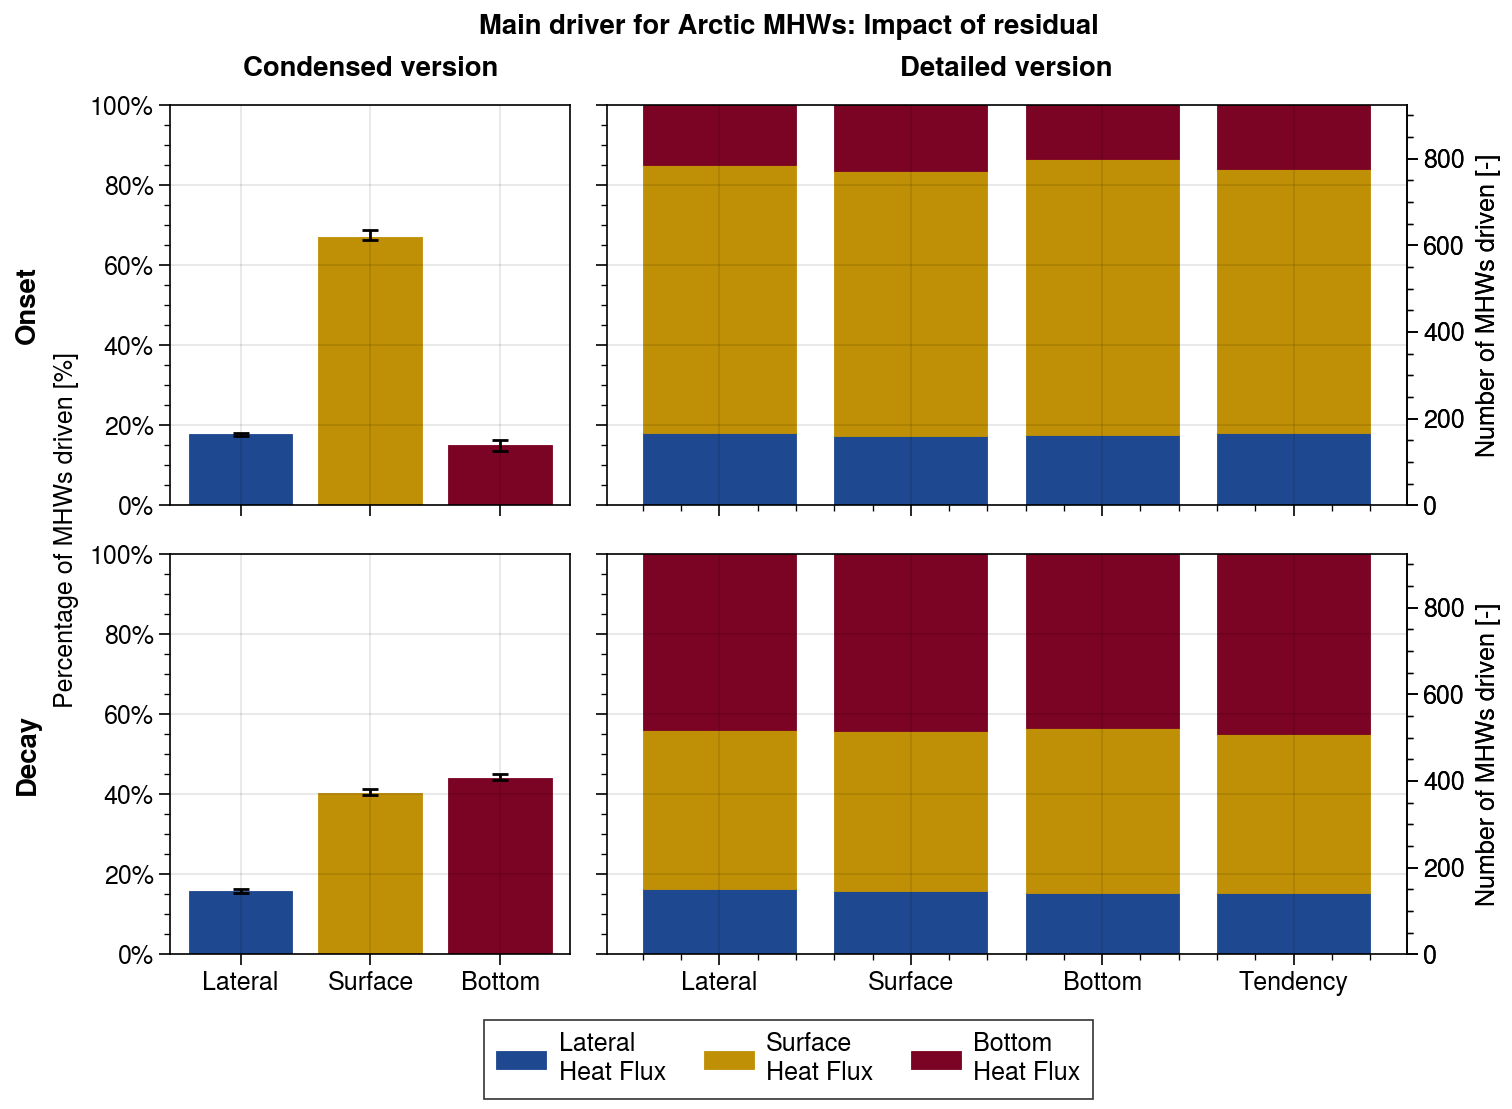

In [18]:
# First, get total number of MHWs detected
nMHW = df_AdvWRes_Onset_ranks.count()[0]
# Plot primary processes, looking at impact of residual attribution 
array=[[1,2,2],[3,4,4]]
fig, axs = pplt.subplots(array,refwidth=2,)
# Onset
# Use the powerful proplot bar method to automaticaly plot the whiskers covering the full range (100)
h_bar = axs[0].bar(df_Onset_rank1/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4],)
# Also plot each individual attribution as one stacked bar plot.
axs[1].bar(df_Onset_rank1/nMHW*100,cycle=CycleHB[1:4],stack=True)
axs[1].dualy(lambda x: x /100 * nMHW,label='Number of MHWs driven [-]') # Dual axis for total number of MHWs
# Decay
axs[2].bar(df_Decay_rank1/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4])
axs[3].bar(df_Decay_rank1/nMHW*100,cycle=CycleHB[1:4],stack=True)
axs[3].dualy(lambda x: x /100 * nMHW,label='Number of MHWs driven [-]')
# Formating
axs.format(leftlabels=['Onset','Decay'],toplabels=['Condensed version','Detailed version'],
           yformatter='percent',ylim=[0,100],ylabel='Percentage of MHWs driven [%]',
          )
axs[2].format(xticklabels=['Lateral','Surface','Bottom'])
axs[3].format(xticklabels=['Lateral','Surface','Bottom','Tendency'])
fig.legend(h_bar[1].get_children(),labels=HBlabel2plot[1:4],loc='b',)
fig.suptitle("Main driver for Arctic MHWs: Impact of residual")

Text(0.5, 0.98, 'Drivers for Arctic Marine Heatwaves')

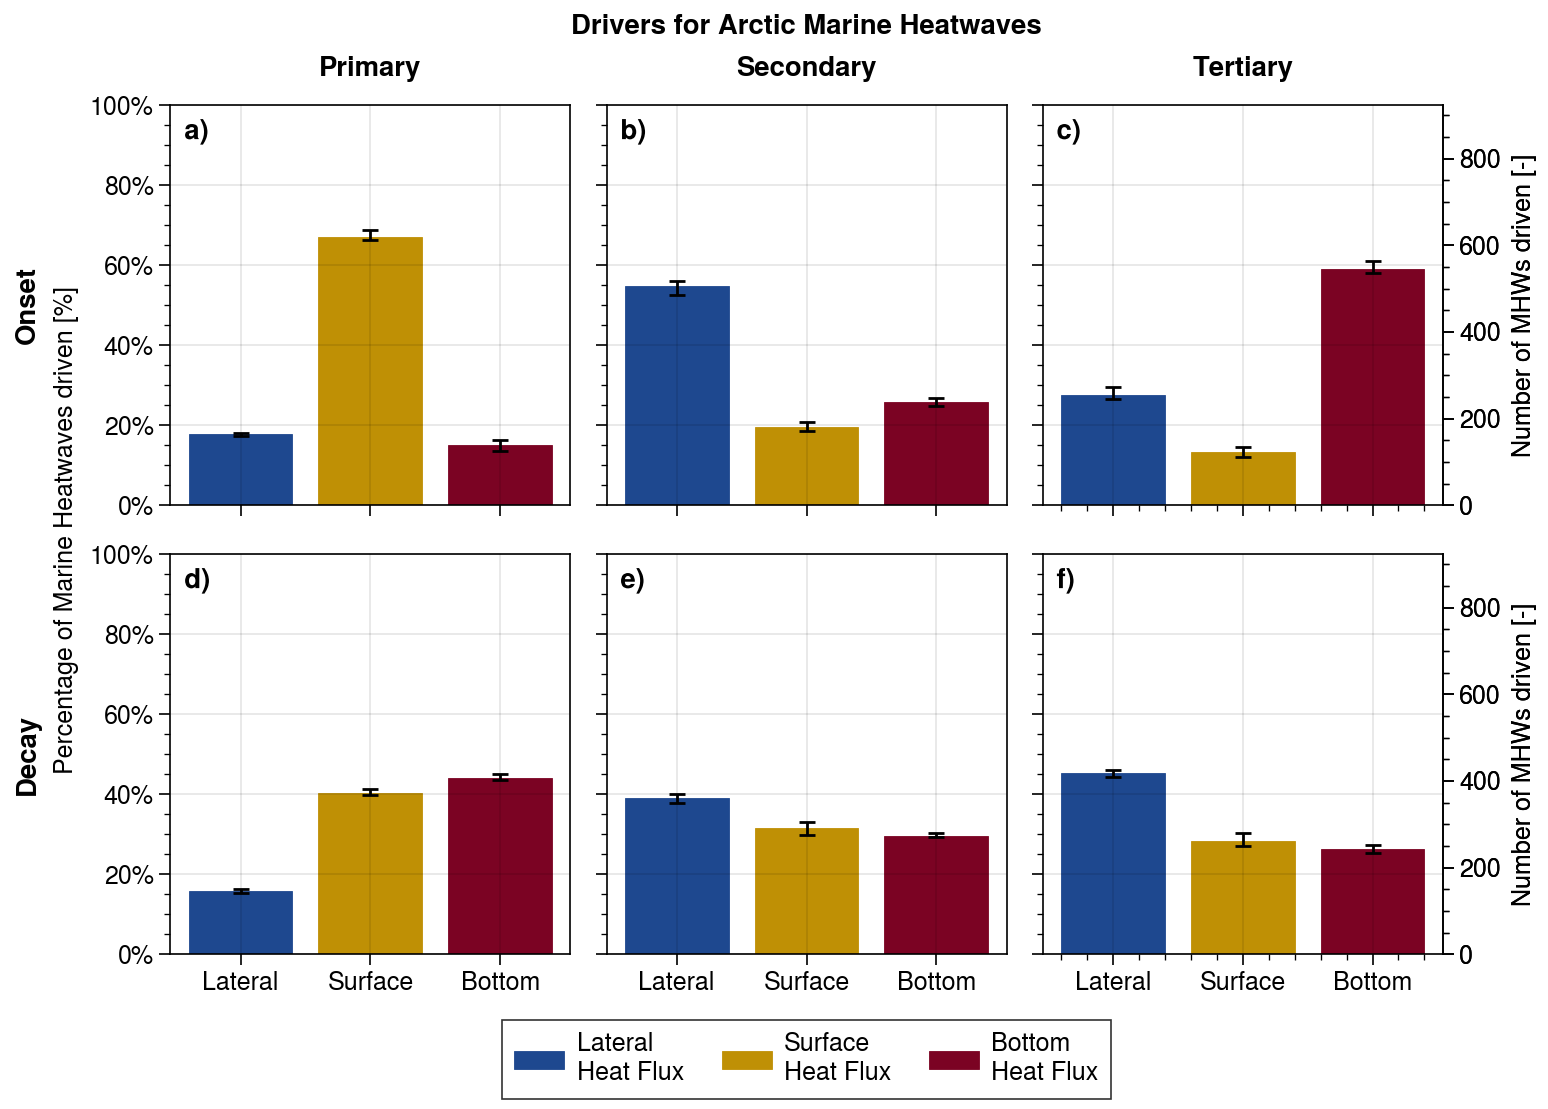

In [19]:
# Use the condensed version of the previous plot for all three main processes.
fig, axs = pplt.subplots(ncols=3,nrows=2,refwidth=2,)
# Onset
h_bar = axs[0].bar(df_Onset_rank1/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4],)
axs[1].bar(df_Onset_rank2/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4],)
axs[2].bar(df_Onset_rank3/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4],)
axs[2].dualy(lambda x: x /100 * nMHW,label='Number of MHWs driven [-]')
# Decay
axs[3].bar(df_Decay_rank1/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4])
axs[4].bar(df_Decay_rank2/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4])
axs[5].bar(df_Decay_rank3/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4])
axs[5].dualy(lambda x: x /100 * nMHW,label='Number of MHWs driven [-]')
# Formating
axs[3:6].format(xticklabels=['Lateral','Surface','Bottom'])
axs.format(leftlabels=['Onset','Decay'],toplabels=['Primary','Secondary','Tertiary'],
           abc='a)', abcloc='ul',
           yformatter='percent',ylim=[0,100],ylabel='Percentage of Marine Heatwaves driven [%]',
          )
fig.legend(h_bar[1].get_children(),labels=HBlabel2plot[1:4],loc='b',)
fig.suptitle("Drivers for Arctic Marine Heatwaves")
# fig.save(Path2figs.joinpath("BarPlot_allMHWDrivers_ranking_wResiduals.png"),dpi=400)

Text(0.5, 0.98, 'Drivers for Arctic Marine Heatwaves')

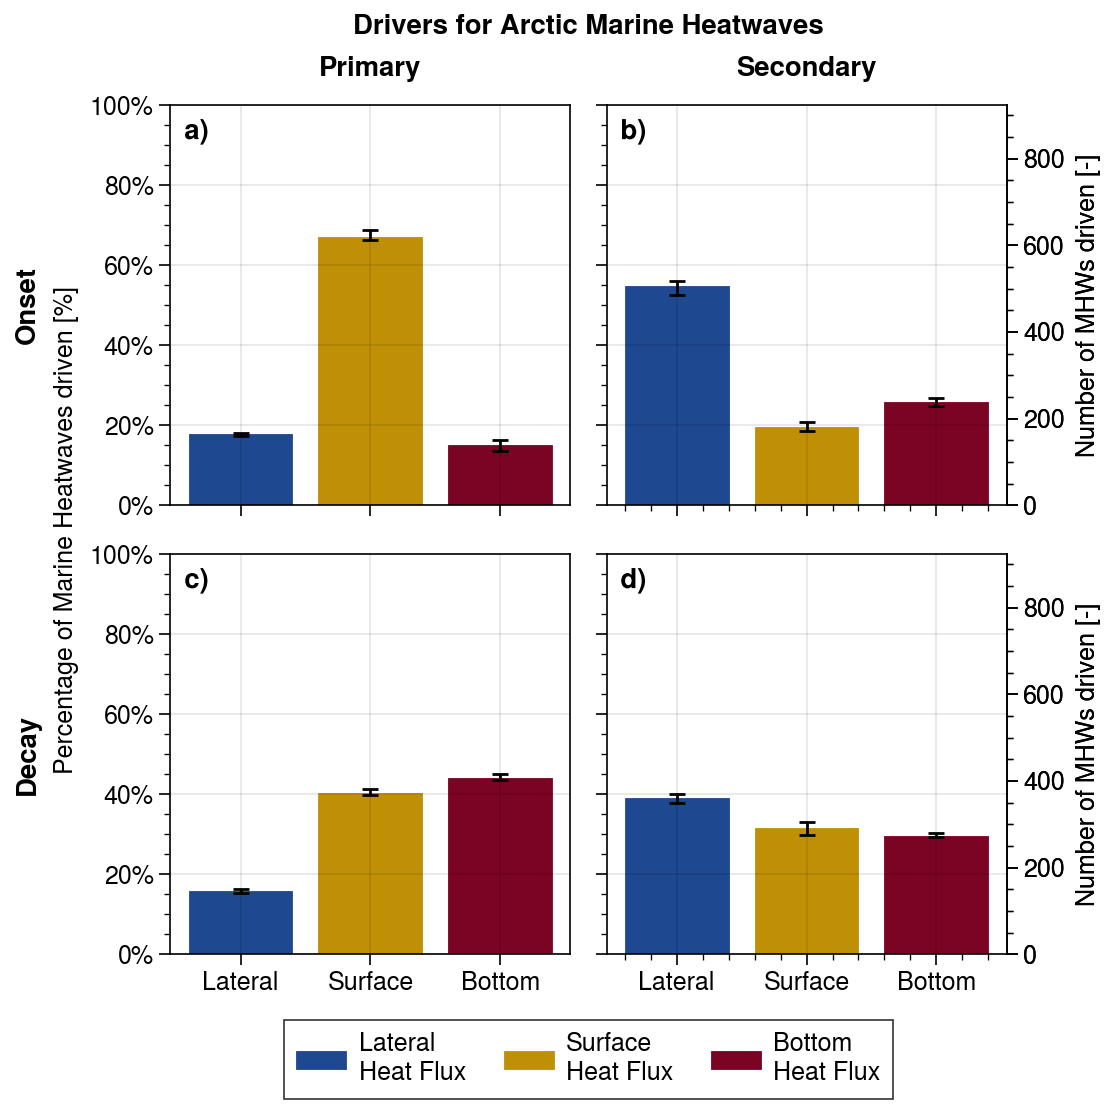

In [20]:
# Second version removing the tertiary driver
fig, axs = pplt.subplots(ncols=2,nrows=2,refwidth=2,)
# Onset
h_bar = axs[0].bar(df_Onset_rank1/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4],)
axs[1].bar(df_Onset_rank2/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4],)
axs[1].dualy(lambda x: x /100 * nMHW,label='Number of MHWs driven [-]')
# Decay
axs[2].bar(df_Decay_rank1/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4],)
axs[3].bar(df_Decay_rank2/nMHW*100,mean=True,barpctile=100,color=CycleHB[1:4])
axs[3].dualy(lambda x: x /100 * nMHW,label='Number of MHWs driven [-]')
# Formatting
axs[2:4].format(xticklabels=['Lateral','Surface','Bottom'])
axs.format(leftlabels=['Onset','Decay'],toplabels=['Primary','Secondary'],
           abc='a)', abcloc='ul',
           yformatter='percent',ylim=[0,100],ylabel='Percentage of Marine Heatwaves driven [%]',
          )
fig.legend(h_bar[1].get_children(),labels=HBlabel2plot[1:4],loc='b',)
fig.suptitle("Drivers for Arctic Marine Heatwaves")
# fig.save(Path2figs.joinpath("BarPlot_allMHWDrivers_ranking_wResiduals_v2.png"),dpi=600)
# fig.save(Path2figs.joinpath("BarPlot_allMHWDrivers_ranking_wResiduals_v2.svg"))#,dpi=600)

#### Scatter maps for spatial distribution
To be able to plot the scatter map, need a bit of pre-processing to calculate the number of MHWs driven by specific process, for each tile.
Following the previous analysis, we are confident the residuals don't play that big of a role in the overall picture and we therefore neglect them for the spatial distribution analysis.

In [21]:
# Transform into pandas dataframe
# Recalculate the ranks, but for each event instead of overall picture.
HBTerms_norm1 = ds_mhw_attr/ ds_mhw_attr.Tendency_top
# Onset
mhw_normDrv1_Onset=HBTerms_norm1.sel(trend='Onset').drop_vars(['Tendency_top','trend','Resi_top'])
df_mhw_normDrv1_Onset = mhw_normDrv1_Onset.to_dataframe(dim_order=('tiles','mhw')).dropna()
#Decay
mhw_normDrv1_Decay=HBTerms_norm1.sel(trend='Decay').drop_vars(['Tendency_top','trend','Resi_top'])
df_mhw_normDrv1_Decay = mhw_normDrv1_Decay.to_dataframe(dim_order=('tiles','mhw')).dropna()
# Then Rank the processes
df_rankDrv1_Onset = df_mhw_normDrv1_Onset.rank(axis=1,ascending=False)
df_rankDrv1_Decay = df_mhw_normDrv1_Decay.rank(axis=1,ascending=False)

In [22]:
# Some pre-defined metrics
CoordsT = ds_HBAnom[['latitude','longitude']] # Coordinates of the tiles.
MHWs_tile = df_rankDrv1_Onset.dropna().groupby('tiles').size() # Number of MHW per tile
# Onset
# For each tile, count the number of MHWs driven by LatAdv heat flux
MHWsperTile_Adv1_Onset = df_rankDrv1_Onset.where(df_rankDrv1_Onset.TotAdv_top==1).dropna().groupby('tiles').size()
MHWsperTile_Adv1_Onset = (MHWsperTile_Adv1_Onset/MHWs_tile).dropna() # Divide by total number of MHWs for this tile
Coords_Onset_Adv1 = CoordsT.sel(tiles=MHWsperTile_Adv1_Onset.index) # Need to extract coords again to match nans
# For each tile, count the number of MHWs driven by Surface heat flux
MHWsperTile_Surf1_Onset = df_rankDrv1_Onset.where(df_rankDrv1_Onset.Qsr_net_top==1).dropna().groupby('tiles').size()
MHWsperTile_Surf1_Onset = (MHWsperTile_Surf1_Onset/MHWs_tile).dropna() # Divide by total number of MHWs for this tile
Coords_Onset_Surf1 = CoordsT.sel(tiles=MHWsperTile_Surf1_Onset.index)
# For each tile, count the number of MHWs driven by Bottom heat flux
MHWsperTile_Bott1_Onset = df_rankDrv1_Onset.where(df_rankDrv1_Onset.Vert_Flux==1).dropna().groupby('tiles').size()
MHWsperTile_Bott1_Onset = (MHWsperTile_Bott1_Onset/MHWs_tile).dropna() # Divide by total number of MHWs for this tile
Coords_Onset_Bott1 = CoordsT.sel(tiles=MHWsperTile_Bott1_Onset.index)
# Decay
# For each tile, count the number of MHWs driven by LatAdv heat flux
MHWsperTile_Adv1_Decay = df_rankDrv1_Decay.where(df_rankDrv1_Decay.TotAdv_top==1).dropna().groupby('tiles').size()
MHWsperTile_Adv1_Decay = (MHWsperTile_Adv1_Decay/MHWs_tile).dropna()
Coords_Decay_Adv1 = CoordsT.sel(tiles=MHWsperTile_Adv1_Decay.index)
# For each tile, count the number of MHWs driven by Surface heat flux
MHWsperTile_Surf1_Decay = df_rankDrv1_Decay.where(df_rankDrv1_Decay.Qsr_net_top==1).dropna().groupby('tiles').size()
MHWsperTile_Surf1_Decay = (MHWsperTile_Surf1_Decay/MHWs_tile).dropna()
Coords_Decay_Surf1 = CoordsT.sel(tiles=MHWsperTile_Surf1_Decay.index)
# For each tile, count the number of MHWs driven by Bottom heat flux
MHWsperTile_Bott1_Decay = df_rankDrv1_Decay.where(df_rankDrv1_Decay.Vert_Flux==1).dropna().groupby('tiles').size()
MHWsperTile_Bott1_Decay = (MHWsperTile_Bott1_Decay/MHWs_tile).dropna()
Coords_Decay_Bott1 = CoordsT.sel(tiles=MHWsperTile_Bott1_Decay.index)

Now can plot the maps

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instant

Text(0.5, 0.98, 'Location of Marine Heatwaves dominated by:')

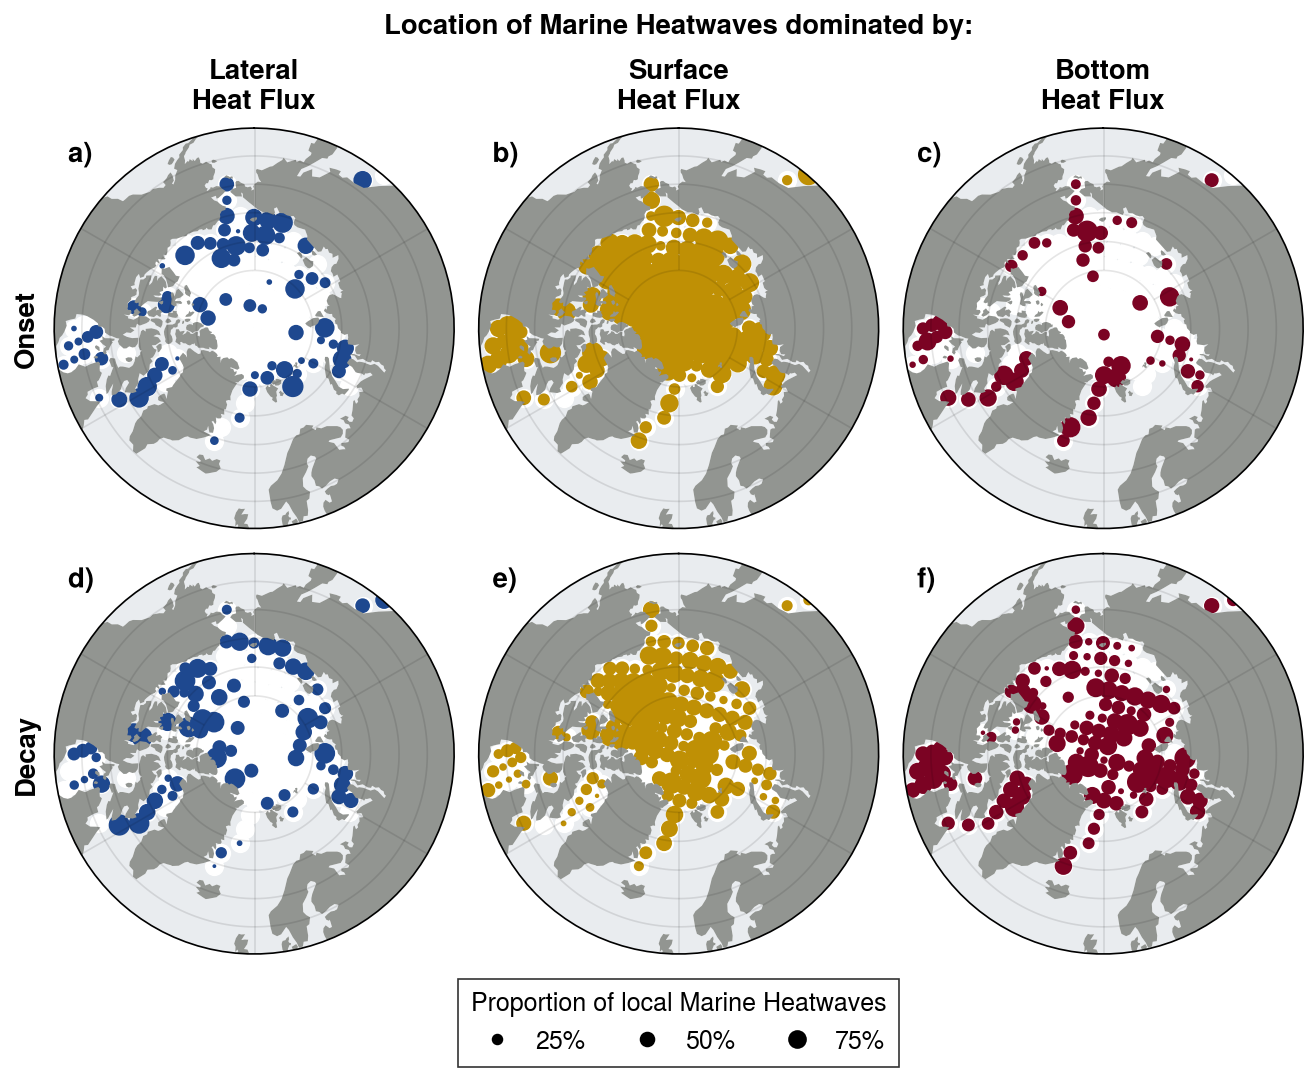

In [23]:
fig,axs = pplt.subplots(nrows=2,ncols=3,proj=proj,refwidth=2)
# Not very elegant, but plot white markers everywhere we have tiles, to differentiate from grey background
for ax in axs:
    ax.scatter(CoordsT.longitude, CoordsT.latitude,
                      s=40, c='w',edgecolor='w', m='o')
# Now can plot the results: Size for proportion of MHWs driven by process.
# Onset
# Advection
sc=axs[0].scatter(Coords_Onset_Adv1.longitude, Coords_Onset_Adv1.latitude,
                  s=MHWsperTile_Adv1_Onset*100, c=CycleHB[1],
                  smin=0, smax=50,) # Need to declare min and max size to keep consistent sizes acrross panels
# Surface
axs[1].scatter(Coords_Onset_Surf1.longitude, Coords_Onset_Surf1.latitude,
               s=MHWsperTile_Surf1_Onset*100, c=CycleHB[2],
                  smin=0, smax=50)
# Bottom
axs[2].scatter(Coords_Onset_Bott1.longitude, Coords_Onset_Bott1.latitude,
               s=MHWsperTile_Bott1_Onset*100, c=CycleHB[3],
                  smin=0, smax=50)
# Decay
# Advection
axs[3].scatter(Coords_Decay_Adv1.longitude, Coords_Decay_Adv1.latitude,
               s=MHWsperTile_Adv1_Decay*100, c=CycleHB[1],
                  smin=0, smax=50)
# Surface
axs[4].scatter(Coords_Decay_Surf1.longitude, Coords_Decay_Surf1.latitude,
               s=MHWsperTile_Surf1_Decay*100, c=CycleHB[2],
                  smin=0, smax=50)
# Bottom
axs[5].scatter(Coords_Decay_Bott1.longitude, Coords_Decay_Bott1.latitude,
               s=MHWsperTile_Bott1_Decay*100, c=CycleHB[3],
                  smin=0, smax=50)
# Some formatting, to put grey background where no data, add land, letter panels on upper left, add top and left labels...
axs.format(boundinglat=55, land=True, landcolor='grey', ocean=True,oceancolor='grey2', oceanzorder=0,
           toplabels=HBlabel2plot[1:4], abc='a)', abcloc='ul',
           leftlabels=['Onset','Decay']
          )
# Add a legend matching the sizes.
fig.legend(*sc.legend_elements("sizes", num=4,func=lambda s: s*2, fmt=pplt.PercentFormatter()),
           loc='b', title='Proportion of local Marine Heatwaves', ncol=4
          )
fig.suptitle("Location of Marine Heatwaves dominated by:")
# fig.save(Path2figs.joinpath("ScatterMaps_FirstDrivers_Spatial.png"),dpi=400)

Do the same for the secondary process

In [24]:
# Some pre-defined metrics
CoordsT = ds_HBAnom[['latitude','longitude']] # Number of MHW per tiles
MHWs_tile = df_rankDrv1_Onset.groupby('tiles').size() # Number of MHW per tiles
# Onset
MHWsperTile_Adv1_Onset = df_rankDrv1_Onset.where(df_rankDrv1_Onset.TotAdv_top==2).dropna().groupby('tiles').size()
MHWsperTile_Adv1_Onset = (MHWsperTile_Adv1_Onset/MHWs_tile).dropna()
Coords_Onset_Adv1 = CoordsT.sel(tiles=MHWsperTile_Adv1_Onset.index)
MHWsperTile_Surf1_Onset = df_rankDrv1_Onset.where(df_rankDrv1_Onset.Qsr_net_top==2).dropna().groupby('tiles').size()
MHWsperTile_Surf1_Onset = (MHWsperTile_Surf1_Onset/MHWs_tile).dropna()
Coords_Onset_Surf1 = CoordsT.sel(tiles=MHWsperTile_Surf1_Onset.index)
MHWsperTile_Bott1_Onset = df_rankDrv1_Onset.where(df_rankDrv1_Onset.Vert_Flux==2).dropna().groupby('tiles').size()
MHWsperTile_Bott1_Onset = (MHWsperTile_Bott1_Onset/MHWs_tile).dropna()
Coords_Onset_Bott1 = CoordsT.sel(tiles=MHWsperTile_Bott1_Onset.index)
# Decline
MHWsperTile_Adv1_Decay = df_rankDrv1_Decay.where(df_rankDrv1_Decay.TotAdv_top==2).dropna().groupby('tiles').size()
MHWsperTile_Adv1_Decay = (MHWsperTile_Adv1_Decay/MHWs_tile).dropna()
Coords_Decay_Adv1 = CoordsT.sel(tiles=MHWsperTile_Adv1_Decay.index)
MHWsperTile_Surf1_Decay = df_rankDrv1_Decay.where(df_rankDrv1_Decay.Qsr_net_top==2).dropna().groupby('tiles').size()
MHWsperTile_Surf1_Decay = (MHWsperTile_Surf1_Decay/MHWs_tile).dropna()
Coords_Decay_Surf1 = CoordsT.sel(tiles=MHWsperTile_Surf1_Decay.index)
MHWsperTile_Bott1_Decay = df_rankDrv1_Decay.where(df_rankDrv1_Decay.Vert_Flux==2).dropna().groupby('tiles').size()
MHWsperTile_Bott1_Decay = (MHWsperTile_Bott1_Decay/MHWs_tile).dropna()
Coords_Decay_Bott1 = CoordsT.sel(tiles=MHWsperTile_Bott1_Decay.index)

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instant

Text(0.5, 0.98, 'Location of MHWs where second driver is:')

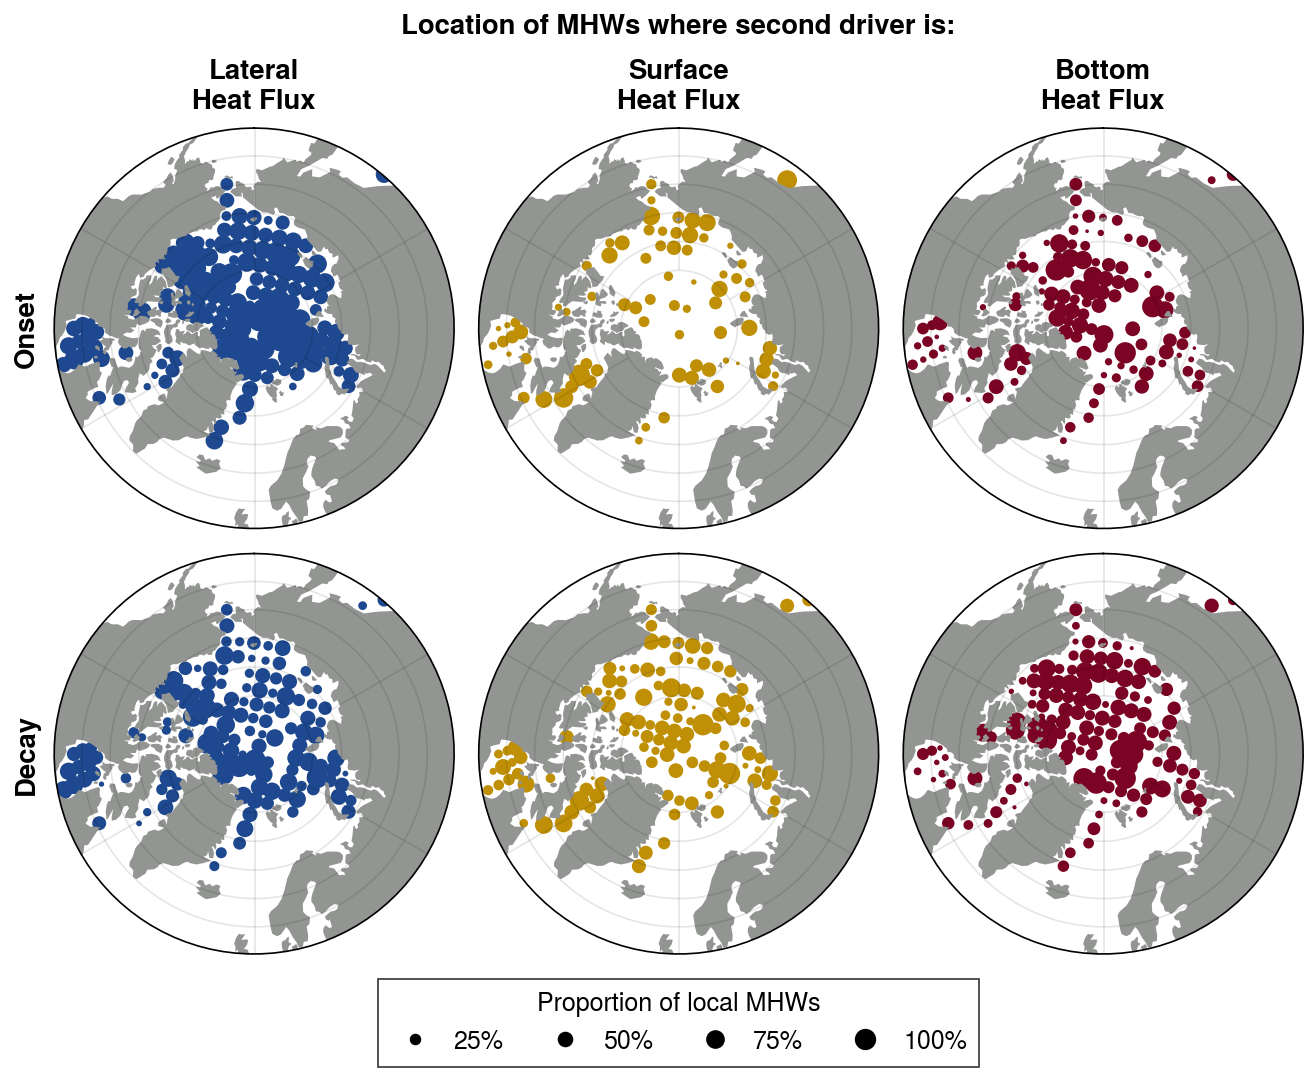

In [25]:
fig,axs = pplt.subplots(nrows=2,ncols=3,proj=proj,refwidth=2)
sc=axs[0].scatter(Coords_Onset_Adv1.longitude, Coords_Onset_Adv1.latitude,
                  s=MHWsperTile_Adv1_Onset*100, c=CycleHB[1],
                  smin=0, smax=50,)
axs[1].scatter(Coords_Onset_Surf1.longitude, Coords_Onset_Surf1.latitude,
               s=MHWsperTile_Surf1_Onset*100, c=CycleHB[2],
                  smin=0, smax=50)
axs[2].scatter(Coords_Onset_Bott1.longitude, Coords_Onset_Bott1.latitude,
               s=MHWsperTile_Bott1_Onset*100, c=CycleHB[3],
                  smin=0, smax=50)
axs[3].scatter(Coords_Decay_Adv1.longitude, Coords_Decay_Adv1.latitude,
               s=MHWsperTile_Adv1_Decay*100, c=CycleHB[1],
                  smin=0, smax=50)
axs[4].scatter(Coords_Decay_Surf1.longitude, Coords_Decay_Surf1.latitude,
               s=MHWsperTile_Surf1_Decay*100, c=CycleHB[2],
                  smin=0, smax=50)
axs[5].scatter(Coords_Decay_Bott1.longitude, Coords_Decay_Bott1.latitude,
               s=MHWsperTile_Bott1_Decay*100, c=CycleHB[3],
                  smin=0, smax=50)
axs.format(boundinglat=55, land=True, landcolor='grey', 
           toplabels=HBlabel2plot[1:4],
           leftlabels=['Onset','Decay']
          )
fig.legend(*sc.legend_elements("sizes", num=4,func=lambda s: s*2, fmt=pplt.PercentFormatter()),
           loc='b', title='Proportion of local MHWs', ncol=4
          )#, fmt='%1.1f%%'))
fig.suptitle("Location of MHWs where second driver is:")

#### Temporal distribution
Some of the drivers might be more prevalent during one season rather than another. So look at the temporal distribution of the primary drivers. To do so, first need a bit of preprocessing to extract each season.

In [26]:
# Extract the peak date and convert it into the "quarter" to get the season.
DatePeak_MHW = ds_mhws_filter.date_peak.drop(['latitude','longitude']).to_dataframe().dropna()
QuarPeak_MHW = DatePeak_MHW['date_peak'].dt.quarter
# For Onset
# Winter
JFM_rank_onset = df_rankDrv1_Onset.where(QuarPeak_MHW==1).dropna(how='all') # Extract MHWs occuring during first quarter
JFM_rank1_onset = JFM_rank_onset.where(JFM_rank_onset==1).count() # Then squeeze by counting primary drivers
# Spring
AMJ_rank_onset = df_rankDrv1_Onset.where(QuarPeak_MHW==2).dropna(how='all')
AMJ_rank1_onset = AMJ_rank_onset.where(AMJ_rank_onset==1).count()
# Summer
JAS_rank_onset = df_rankDrv1_Onset.where(QuarPeak_MHW==3).dropna(how='all')
JAS_rank1_onset = JAS_rank_onset.where(JAS_rank_onset==1).count()
# Automn
OND_rank_onset = df_rankDrv1_Onset.where(QuarPeak_MHW==4).dropna(how='all')
OND_rank1_onset = OND_rank_onset.where(OND_rank_onset==1).count()
# For Decay
# Winter
JFM_rank_decay = df_rankDrv1_Decay.where(QuarPeak_MHW==1).dropna(how='all')
JFM_rank1_decay = JFM_rank_decay.where(JFM_rank_decay==1).count()
# Spring
AMJ_rank_decay = df_rankDrv1_Decay.where(QuarPeak_MHW==2).dropna(how='all')
AMJ_rank1_decay = AMJ_rank_decay.where(AMJ_rank_decay==1).count()
# Summer
JAS_rank_decay = df_rankDrv1_Decay.where(QuarPeak_MHW==3).dropna(how='all')
JAS_rank1_decay = JAS_rank_decay.where(JAS_rank_decay==1).count()
# Automn
OND_rank_decay = df_rankDrv1_Decay.where(QuarPeak_MHW==4).dropna(how='all')
OND_rank1_decay = OND_rank_decay.where(OND_rank_decay==1).count()

Plot the results

Text(0.5, 0.98, 'Seasonality of dominant driver, Onset')

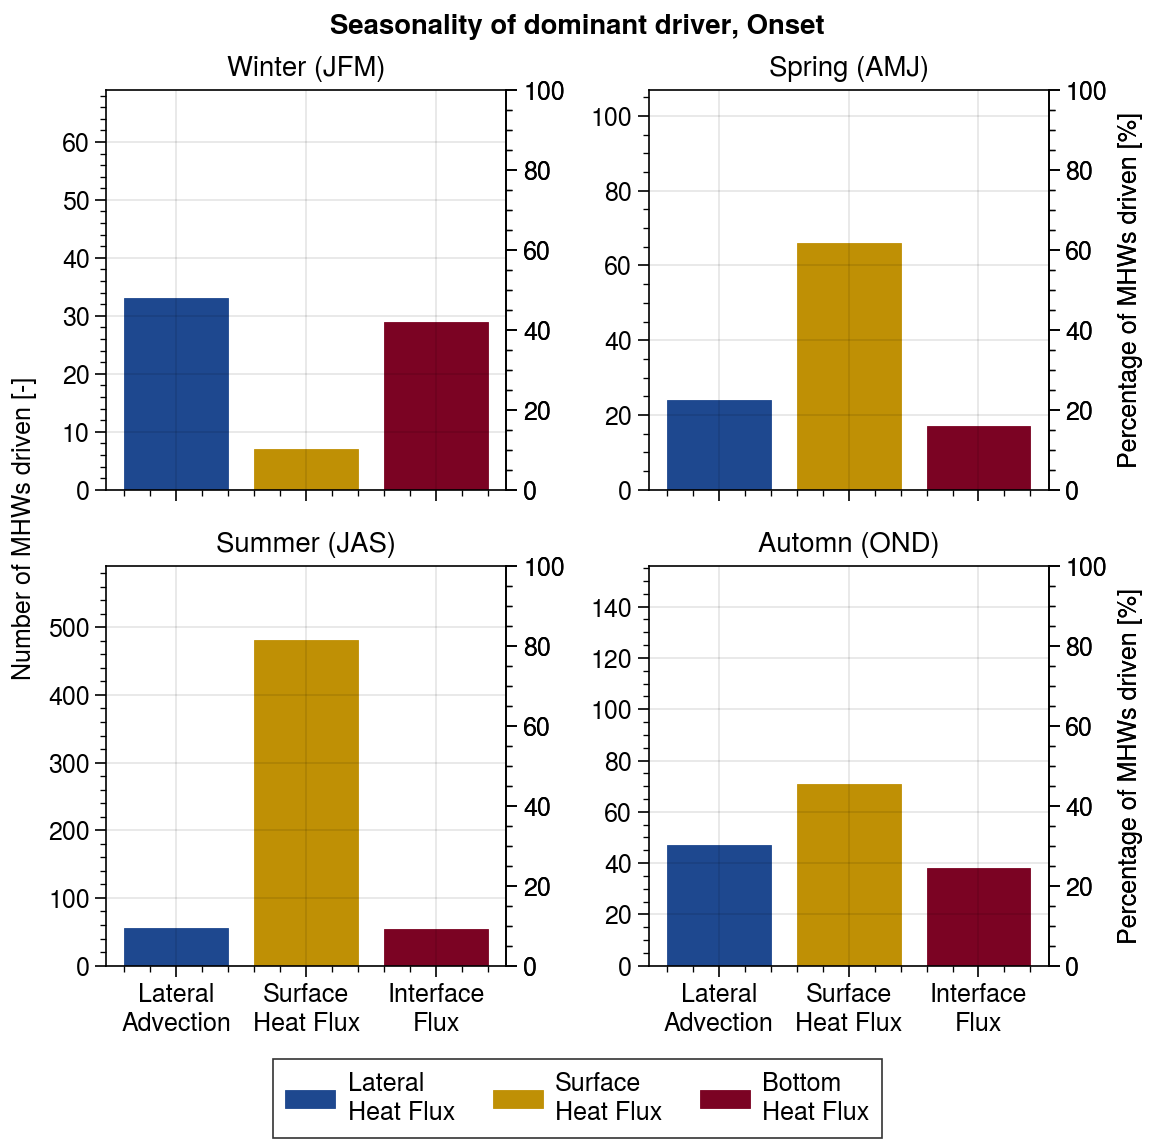

In [27]:
# Start by Onset only, for simplicity
fig, axs = pplt.subplots(ncols=2,nrows=2,refwidth=2,sharey=1)
# Plot bar plots for winter
h_bar = axs[0].bar(JFM_rank1_onset,color=CycleHB[1:4],)
axs[0].dualy(lambda x: x / JFM_rank1_onset.sum() * 100)#,label='Percentage of MHWs driven [%]')
axs[0].format(title='Winter (JFM)', ylim=[0,JFM_rank1_onset.sum()])
# Plot bar plots for Spring
axs[1].bar(AMJ_rank1_onset,color=CycleHB[1:4])
axs[1].dualy(lambda x: x / AMJ_rank1_onset.sum() * 100,label='Percentage of MHWs driven [%]')
axs[1].format(title='Spring (AMJ)', ylim=[0,AMJ_rank1_onset.sum()])
# Plot bar plots for Summer
axs[2].bar(JAS_rank1_onset,color=CycleHB[1:4],)
axs[2].dualy(lambda x: x / JAS_rank1_onset.sum() * 100)#,label='Percentage of MHWs driven [%]')
axs[2].format(title='Summer (JAS)', ylim=[0,JAS_rank1_onset.sum()])
# Plot bar plots for Fall
axs[3].bar(OND_rank1_onset,color=CycleHB[1:4])
axs[3].dualy(lambda x: x / OND_rank1_onset.sum() * 100,label='Percentage of MHWs driven [%]')
axs[3].format(title='Automn (OND)', ylim=[0,OND_rank1_onset.sum()])
# Formatting
axs.format(ylabel='Number of MHWs driven [-]',
           xticklabels=['Lateral\nAdvection','Surface\nHeat Flux','Interface\nFlux']
          )
fig.legend(h_bar.get_children(),labels=HBlabel2plot[1:4],loc='b',)
fig.suptitle("Seasonality of dominant driver, Onset")

Now can do the same for both onset and decay

Text(0.5, 0.98, 'Seasonality of Primary process')

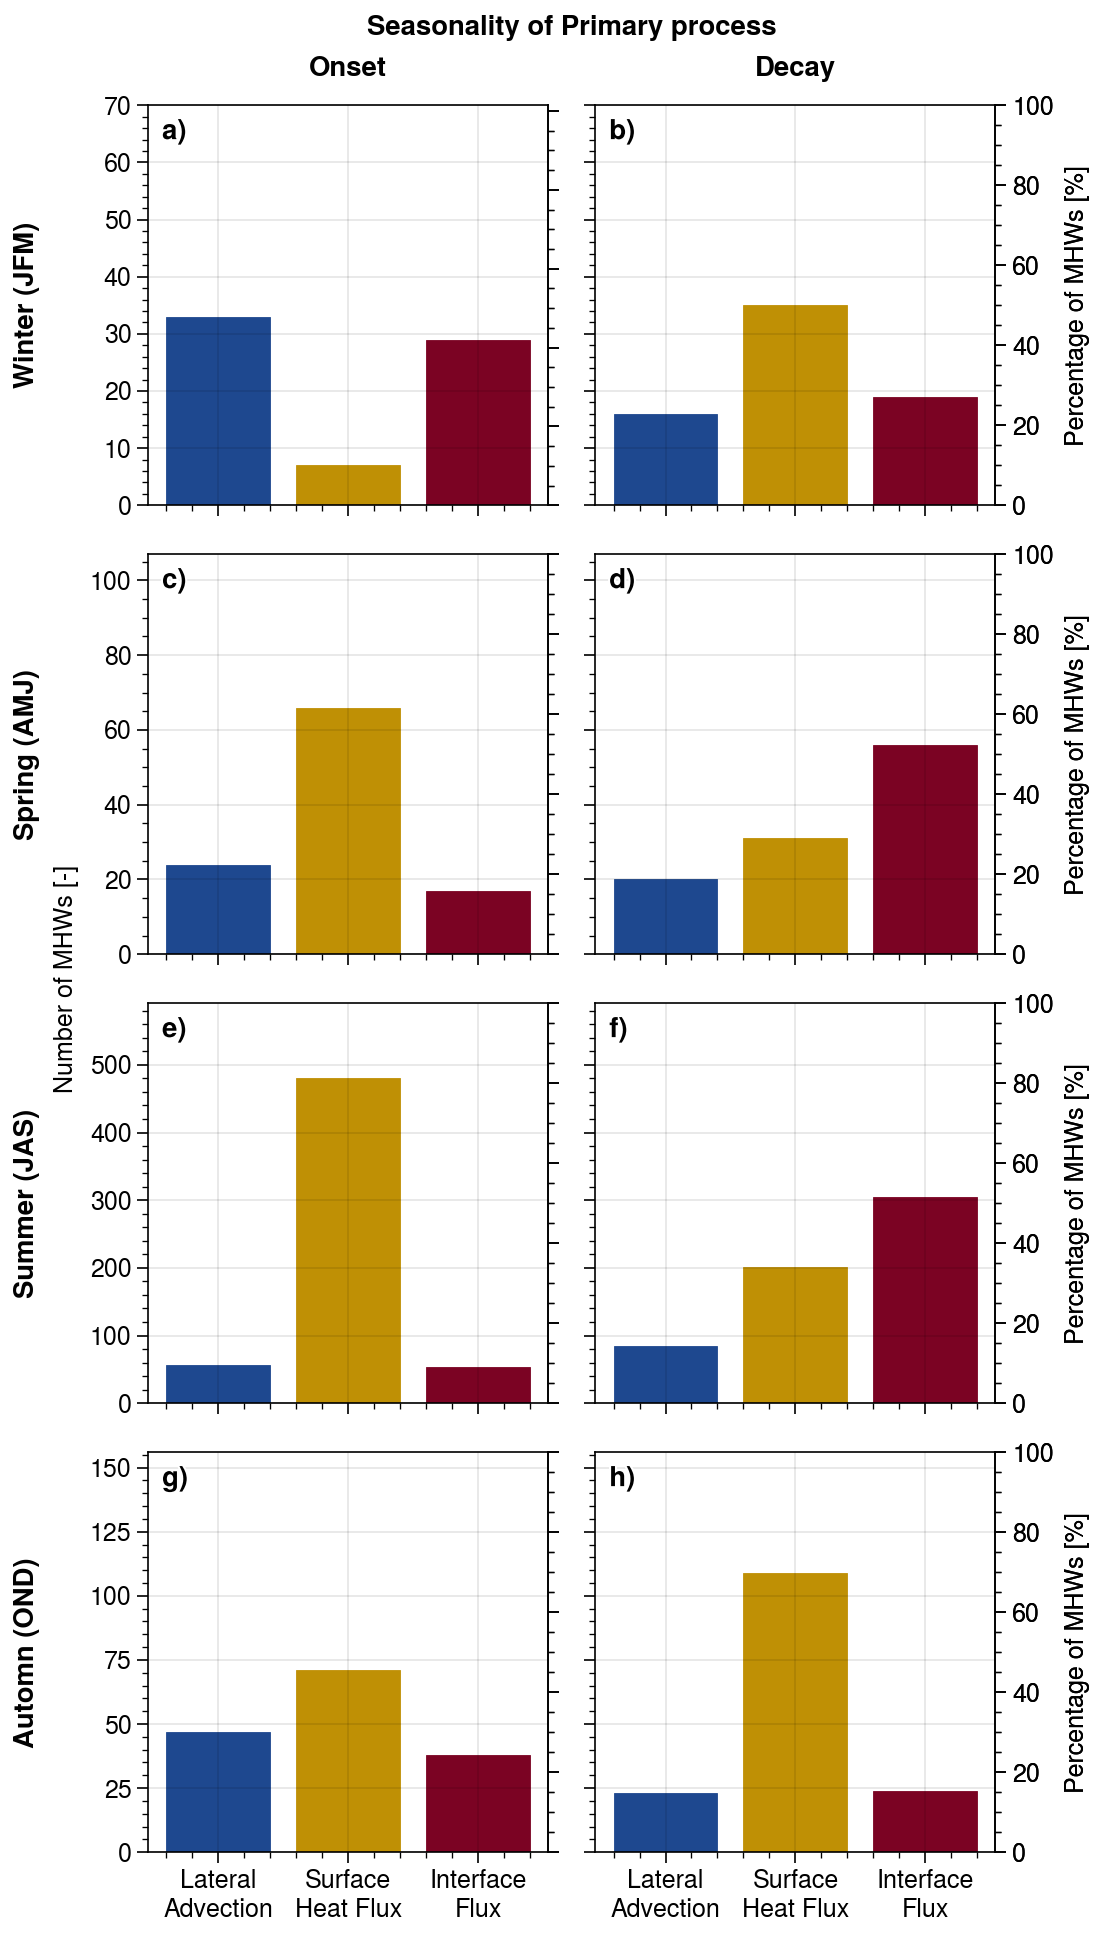

In [28]:
fig, axs = pplt.subplots(ncols=2,nrows=4,refwidth=2,sharey=3,sharex=4,abc='a)',abcloc='ul')
# Onset
# Winter
h_bar = axs[0].bar(JFM_rank1_onset,color=CycleHB[1:4],)
axs[0].dualy(lambda x: x / JFM_rank1_onset.sum() * 100, yformatter='none')
axs[0].format(ylim=[0,JFM_rank1_onset.sum()])
#Spring
axs[2].bar(AMJ_rank1_onset,color=CycleHB[1:4])
axs[2].dualy(lambda x: x / AMJ_rank1_onset.sum() * 100, yformatter='none')
axs[2].format(ylim=[0,AMJ_rank1_onset.sum()])
#Summer
axs[4].bar(JAS_rank1_onset,color=CycleHB[1:4],)
axs[4].dualy(lambda x: x / JAS_rank1_onset.sum() * 100, yformatter='none')
axs[4].format(ylim=[0,JAS_rank1_onset.sum()])
# Fall
axs[6].bar(OND_rank1_onset,color=CycleHB[1:4])
axs[6].dualy(lambda x: x / OND_rank1_onset.sum() * 100, yformatter='none')
axs[6].format(ylim=[0,OND_rank1_onset.sum()])
# Decay
# Winter
h_bar = axs[1].bar(JFM_rank1_decay,color=CycleHB[1:4],)
axs[1].dualy(lambda x: x / JFM_rank1_decay.sum() * 100,label='Percentage of MHWs [%]')
axs[1].format(ylim=[0,JFM_rank1_decay.sum()])
#Spring
axs[3].bar(AMJ_rank1_decay,color=CycleHB[1:4])
axs[3].dualy(lambda x: x / AMJ_rank1_decay.sum() * 100,label='Percentage of MHWs [%]')
axs[3].format(ylim=[0,AMJ_rank1_decay.sum()])
#Summer
axs[5].bar(JAS_rank1_decay,color=CycleHB[1:4],)
axs[5].dualy(lambda x: x / JAS_rank1_decay.sum() * 100,label='Percentage of MHWs [%]')
axs[5].format(ylim=[0,JAS_rank1_decay.sum()])
# Fall
axs[7].bar(OND_rank1_decay,color=CycleHB[1:4])
axs[7].dualy(lambda x: x / OND_rank1_decay.sum() * 100,label='Percentage of MHWs [%]')
axs[7].format(ylim=[0,OND_rank1_decay.sum()])
# Some formatting
axs.format(ylabel='Number of MHWs [-]',
           xticklabels=['Lateral\nAdvection','Surface\nHeat Flux','Interface\nFlux'],
           toplabels=['Onset','Decay'],
           leftlabels=['Winter (JFM)','Spring (AMJ)','Summer (JAS)','Automn (OND)']
          )
fig.suptitle("Seasonality of Primary process")
# fig.save(Path2figs.joinpath("SuppFig2_MHWSeasonality_PrimeProc_OnsetDecay.png"),dpi=400)

Another, more concise way to look at the same data is to stack everything together. One of the limitations of the previous bar chart presentation is that the y limits are not the same for all seasons, because there are more MHWs in summer than winter. So I can stack all them together and plot in one panel.

In [29]:
# Need to rearrange a bit the data to plot with one simple command.
# Onset
AllSeas_onset_percent = pd.concat([JFM_rank1_onset / JFM_rank1_onset.sum(),
           AMJ_rank1_onset / AMJ_rank1_onset.sum(),
           JAS_rank1_onset / JAS_rank1_onset.sum(),
           OND_rank1_onset / OND_rank1_onset.sum()],  # Divide by total number of MHWs for each season
                    axis=1, keys=['JFM','AMJ','JAS','OND']).transpose() # Concatenate together.
AllSeas_onset_abs = pd.concat([JFM_rank1_onset,AMJ_rank1_onset,JAS_rank1_onset,OND_rank1_onset],
                    axis=1, keys=['JFM','AMJ','JAS','OND']).transpose()
# Decay
AllSeas_decay_percent = pd.concat([JFM_rank1_decay / JFM_rank1_decay.sum(),
           AMJ_rank1_decay / AMJ_rank1_decay.sum(),
           JAS_rank1_decay / JAS_rank1_decay.sum(),
           OND_rank1_decay / OND_rank1_decay.sum()],
                    axis=1, keys=['JFM','AMJ','JAS','OND']).transpose()
AllSeas_decay_abs = pd.concat([JFM_rank1_decay,AMJ_rank1_decay,JAS_rank1_decay,OND_rank1_decay],
                    axis=1, keys=['JFM','AMJ','JAS','OND']).transpose()

Text(0.5, 0.98, 'Seasonality of Dominant Drivers')

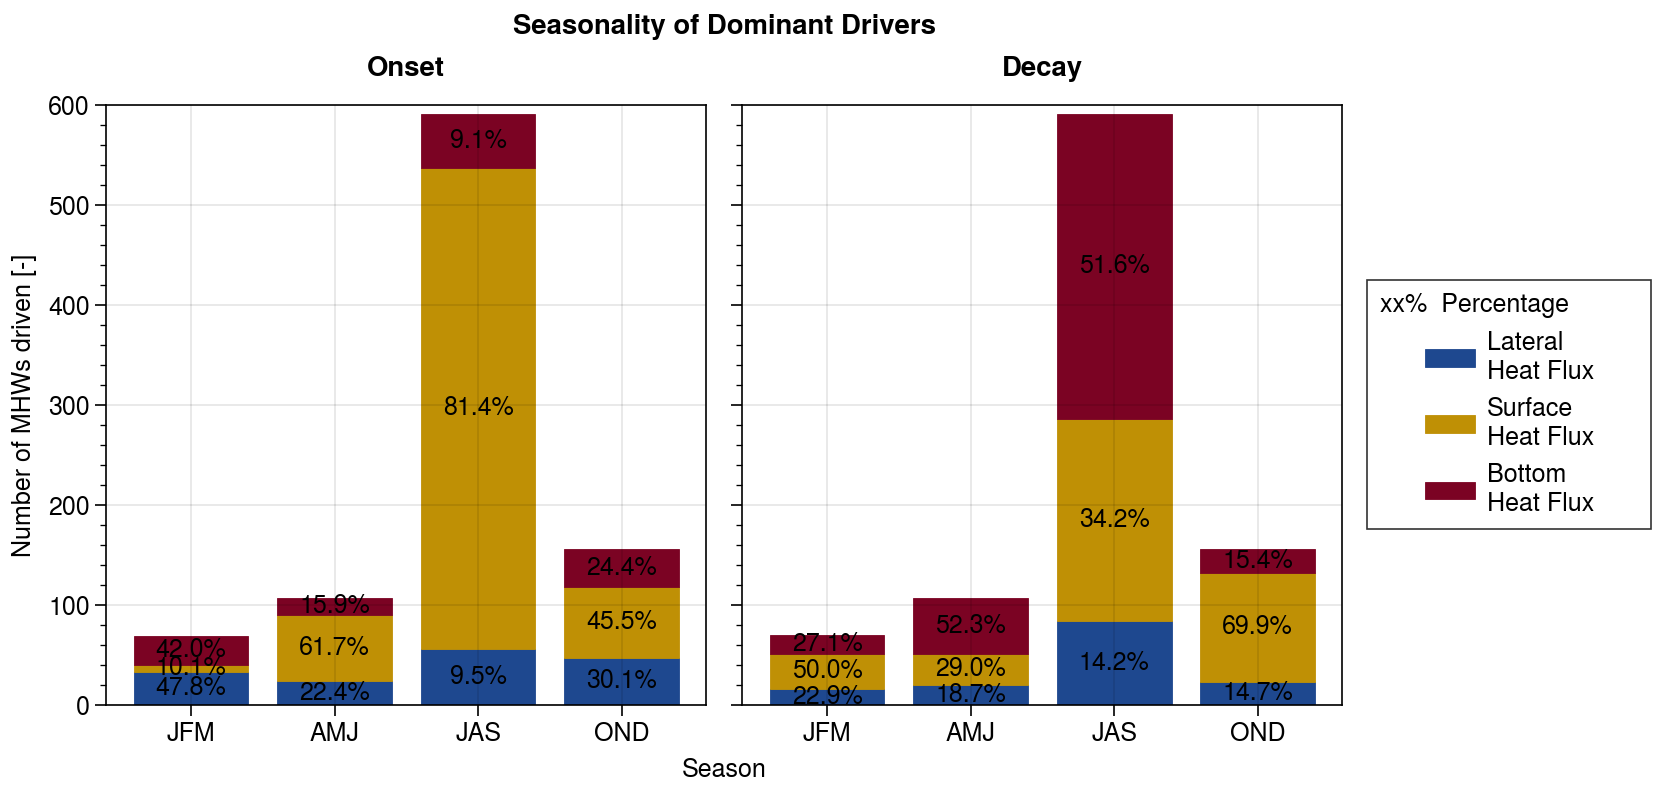

In [30]:
# Same as above, but one panel and all stacked
fig, axs = pplt.subplots(ncols=2,refwidth=3)
# Onset
h_bar = axs[0].bar(AllSeas_onset_abs,stacked=True,cycle=CycleHB[1:4]) # Use absolute numbers for the bar charts
for ii, c in enumerate(axs[0].containers): # But use the percentage for the labels. Loop over bar section.
    axs[0].bar_label(c, labels=[f'{x:.1%}' for x in AllSeas_onset_percent.values[:,ii]], label_type='center')
# Decay
h_bar = axs[1].bar(AllSeas_decay_abs,stacked=True,cycle=CycleHB[1:4])
for ii, c in enumerate(axs[1].containers):
    axs[1].bar_label(c, labels=[f'{x:.1%}' for x in AllSeas_decay_percent.values[:,ii]],label_type='center'
                    )
# Formatting
axs.format(xlabel='Season',ylabel='Number of MHWs driven [-]',toplabels=['Onset','Decay'],ylim=[0,600])
fig.legend(h_bar,labels=HBlabel2plot[1:4],loc='r',ncol=1,
           title='xx%  Percentage          '
          )
fig.suptitle("Seasonality of Dominant Drivers")
# fig.save(Path2figs.joinpath("BarPlot_SeasonalityDriver1_Abso.png"),dpi=400)